In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from GAKELM import GeneticELMRegressor
from sklearn_extensions.extreme_learning_machines import elm
from sklearn import svm
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint
import os
import math

In [3]:
# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

# Min-Max Scalers for normalization
sc1 = MinMaxScaler(feature_range=(0, 1))
sc2 = MinMaxScaler(feature_range=(0, 1))

In [5]:
# Interpolation function for handling missing and outlier values
def interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:, j])
        X[mask_j, j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j, j])
    return X

In [6]:
# Load and preprocess dataset
dataset = pd.read_csv("Dataset.csv")
dataset.fillna(0, inplace=True)


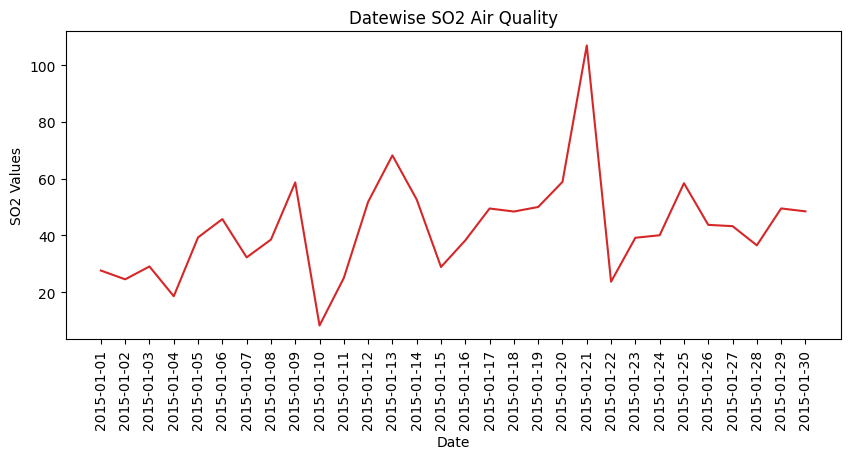

In [7]:
# Visualization: Datewise SO2 Air Quality
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(dataset['Date'][:30], dataset['SO2'][:30], color='tab:red')
plt.title("Datewise SO2 Air Quality")
plt.xlabel('Date')
plt.ylabel("SO2 Values")
plt.xticks(rotation=90)
plt.show()

In [8]:
# Extract target and features
Y = dataset[['PM2.5']].values
dataset.drop(['City', 'Date', 'PM2.5', 'AQI_Bucket'], axis=1, inplace=True)
X = dataset.iloc[:, 3:].values


In [9]:

# Handle missing values
X = interpolate_nans(X)

# Normalize data
X = sc1.fit_transform(X)
Y = sc2.fit_transform(Y)

print("Normalized Training Features:")
print(X)


Normalized Training Features:
[[0.03667429 0.         0.00523292 ... 0.00004397 0.         0.        ]
 [0.03519877 0.         0.00551732 ... 0.0120919  0.02212831 0.        ]
 [0.06351175 0.         0.09897048 ... 0.03605584 0.01320655 0.        ]
 ...
 [0.03919766 0.0303494  0.00273022 ... 0.00002199 0.         0.03318692]
 [0.04020272 0.02842245 0.00295774 ... 0.         0.         0.02635432]
 [0.03004512 0.01473547 0.0033559  ... 0.         0.         0.02440215]]


In [10]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Total records: {X.shape[0]}, Features: {X.shape[1]}")
print(f"Training: {X_train.shape[0]}, Testing: {X_test.shape[0]}")

Total records: 29531, Features: 9
Training: 23624, Testing: 5907


In [1]:
# Metric calculation function
def calculate_metrics(algorithm, predict, test_labels):
    # Reshape predict and test_labels to 2D for MinMaxScaler
    predict = sc2.inverse_transform(np.abs(predict).reshape(-1, 1))  # Reshape to 2D
    test_labels = sc2.inverse_transform(test_labels.reshape(-1, 1))  # Reshape to 2D

    mse_value = mean_squared_error(test_labels, predict) / 100
    rmse_value = np.sqrt(mse_value)
    
    print(f"{algorithm} - MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}")
    plt.plot(test_labels, color='red', label='Original Air Quality PM10')
    plt.plot(predict, color='green', label='Predicted Air Quality PM10')
    plt.title(f"{algorithm} Air Quality Prediction")
    plt.xlabel('Test Data')
    plt.ylabel('Predicted Air Quality')
    plt.legend()
    plt.show()
    
    return mse_value, rmse_value

SVM - MSE: 36.3650, RMSE: 6.0303


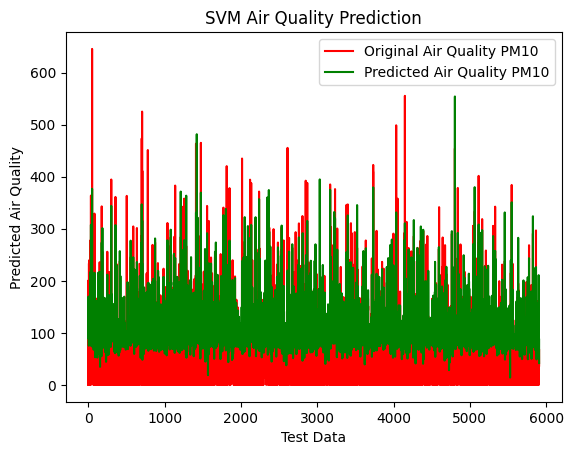

In [12]:
# Train and test SVM
svm_cls = svm.SVR()
svm_cls.fit(X_train, y_train.ravel())
svm_predict = svm_cls.predict(X_test).reshape(-1, 1)
svm_mse, svm_rmse = calculate_metrics("SVM", svm_predict, y_test)

Generation 1/10, Fitness (RMSE): 0.3556
Generation 2/10, Fitness (RMSE): 0.3457
Generation 3/10, Fitness (RMSE): 0.4028
Generation 4/10, Fitness (RMSE): 0.2764
Generation 5/10, Fitness (RMSE): 0.3286
Generation 6/10, Fitness (RMSE): 0.3982
Generation 7/10, Fitness (RMSE): 0.3200
Generation 8/10, Fitness (RMSE): 0.2812
Generation 9/10, Fitness (RMSE): 0.2883
Generation 10/10, Fitness (RMSE): 0.3745
Propose GA-KELM - MSE: 1185.6265, RMSE: 34.4329


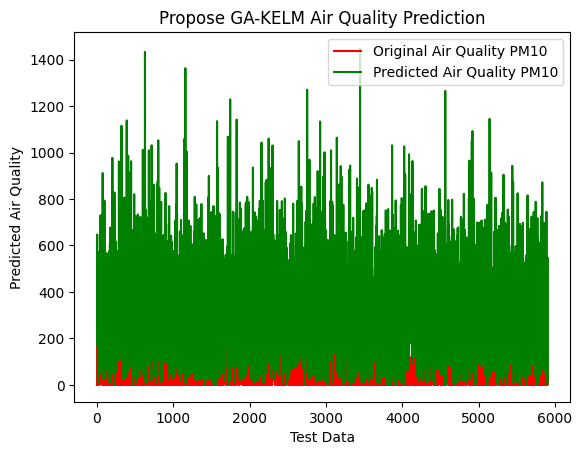

In [13]:
# Create and train the Genetic ELM regressor object
elm = GeneticELMRegressor()
elm.fit(X_train, y_train.ravel())  # Train on the training data

# Perform prediction on test data
predict = elm.predict(X_test)

# Calculate the evaluation metrics (MSE and RMSE)
GELM_MSE, GELM_RMSE =calculate_metrics("Propose GA-KELM", predict, y_test)


C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034
Epoch 1: val_loss improved from inf to 0.00228, saving model to model/extension_weights.keras
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 156s 23ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 2/5
5905/5906 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 2: val_loss improved from 0.00228 to 0.00142, saving model to model/extension_weights.keras
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 137s 23ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 3/5
5904/5906 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0021
Epoch 3: val_loss did not improve from 0.00142
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 276s 47ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/5
5904/5906 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 4: val_loss did not improve from 0.00142
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 409s 69ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/5
5905/5906 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019
Epoch 5: val_loss did not improve from 0.00142
59

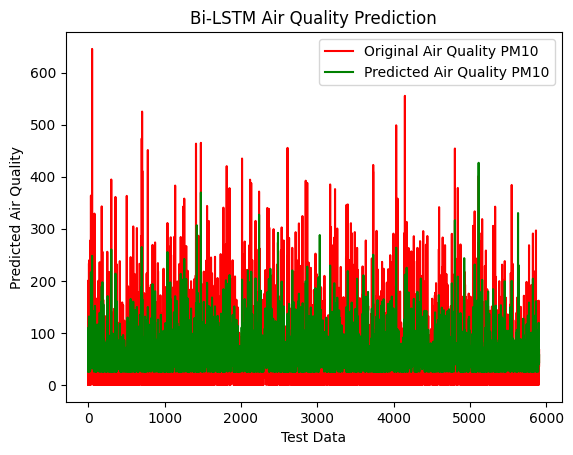

In [14]:
# Train and test Bi-LSTM
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

extension = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train1.shape[1], 1))),
    Dropout(0.5),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(50)),
    Dropout(0.5),
    Dense(1)
])

extension.compile(optimizer='adam', loss='mean_squared_error')

if not os.path.exists('model/extension_weights.hdf5'):
    model_checkpoint = ModelCheckpoint('model/extension_weights.keras', save_best_only=True, verbose=1) # Changed file extension to .keras
    extension.fit(X_train1, y_train, epochs=5, batch_size=4, validation_data=(X_test1, y_test), callbacks=[model_checkpoint], verbose=1)
else:
    extension = load_model('model/extension_weights.hdf5')

bi_lstm_predict = extension.predict(X_test1)
bi_lstm_mse, bi_lstm_rmse = calculate_metrics("Bi-LSTM", bi_lstm_predict, y_test)


In [15]:
# Compare algorithms
results = pd.DataFrame({
    'Algorithm': ['SVM','GeneticALG', 'Bi-LSTM'],
    'MSE': [svm_mse,GELM_MSE, bi_lstm_mse],
    'RMSE': [svm_rmse,GELM_RMSE, bi_lstm_rmse]
})

print("Performance comparison:")
print(results)

Performance comparison:
    Algorithm          MSE       RMSE
0         SVM    36.365010   6.030341
1  GeneticALG  1185.626546  34.432928
2     Bi-LSTM    16.196199   4.024450


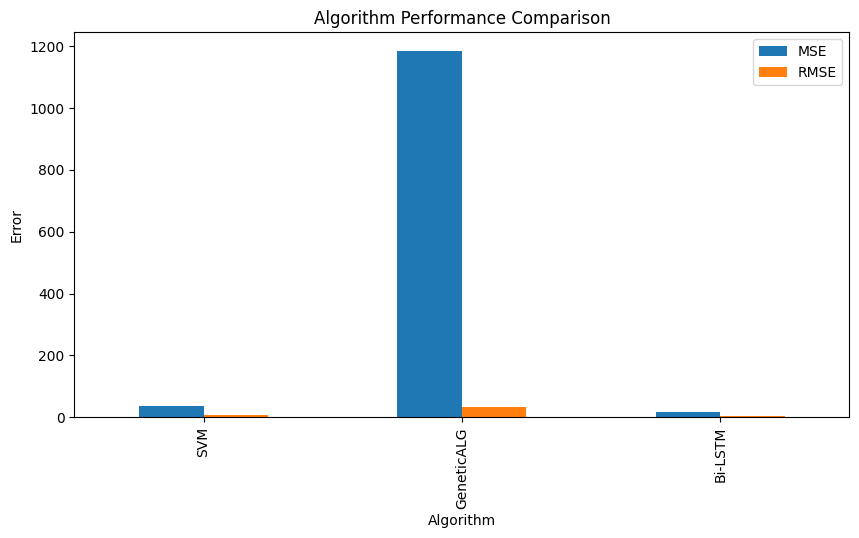

In [16]:
# Plot comparison
results.set_index('Algorithm')[['MSE', 'RMSE']].plot(kind='bar', figsize=(10, 5), title="Algorithm Performance Comparison")
plt.ylabel("Error")
plt.show()